### **rnnを実装してみる**

## **必要な関数・ライブラリ等の準備**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

## **データの準備**

In [4]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    output_data = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # train_kwhをエクセル等で開くとdatetimeが指数表示に直される可能性がある
    # その場合うまくいかないので201201010120の形になってることを確認する必要あり
    output_data = pd.read_csv('data/raw_data/train_kwh.tsv', delimiter = '\t')

    # datetimeの行をpd.Timestampのインスタンスに変更
    output_data = set_time(output_data, 'datetime')
    output_data['datetime'] = output_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに合計を集計
    output_data = output_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).sum()

    output_data.to_csv('data/processed_data/out_put.tsv', sep='\t') 
    
output_data.head()

,datetime,SOLA01,SOLA02,SOLA03
0,2012-01-01 00:00:00,0,0.0,NaN
1,2012-01-01 00:30:00,0,0.0,NaN
2,2012-01-01 01:00:00,0,0.0,NaN
3,2012-01-01 01:30:00,0,0.0,NaN
4,2012-01-01 02:00:00,0,0.0,NaN


In [5]:
# データの読み込み
# 処理済みデータを読み込む。無かったら作る
try:
    amd_data = pd.read_csv('data/processed_data/amd_data.tsv', delimiter='\t')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))
    
except:
    # 河口湖アメダスのデータを使って予測する, amd_49251
    # 各amdidはamd_masterに記載されている
    amd_data = pd.read_csv('data/raw_data/amd_49251.tsv', delimiter = '\t')

    amd_data = set_time(amd_data, 'datetime')
    amd_data['datetime'] = amd_data['datetime'].map(lambda x : pd.to_datetime(x))

    # 30分ごとに平均を集計
    amd_data = amd_data.set_index('datetime').groupby(pd.TimeGrouper(freq='1800s', closed='left')).mean()

    amd_data.to_csv('data/processed_data/amd_data.tsv', sep='\t')

amd_data.head()

,datetime,pr,f_pr,max_ws,f_max_ws,ave_wv,f_ave_wv,ave_ws,f_ave_ws,max_tp,f_max_tp,min_tp,f_min_tp,sl,f_sl,sd,f_sd,dsd,f_dsd
0,2012-01-01 00:00:00,0.0,0.0,22.333333,0.0,20.333333,0.0,10.000000,0.0,-15.666667,0.0,-26.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,2012-01-01 00:30:00,0.0,0.0,15.333333,0.0,25.000000,0.0,9.333333,0.0,-34.666667,0.0,-40.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,0.0,0.0,20.000000,0.0,25.000000,0.0,10.666667,0.0,-35.333333,0.0,-43.666667,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,0.0,0.0,20.333333,0.0,21.666667,0.0,11.333333,0.0,-36.666667,0.0,-42.333333,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,0.0,0.0,25.333333,0.0,21.000000,0.0,13.333333,0.0,-40.666667,0.0,-48.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [6]:
# モデル構築のためにデータを分割する

# 日射量の欠損値を一つ前の値で置換/output_dataに関してはSOLA01はnullなし
amd_data['sl'] = amd_data['sl'].fillna(method='bfill')

# 学習に必要なデータ
# 2012/01/01 00:00 ~ 2015/12/30 20:00のamdデータを用いて
# 2012/01/03 03:30 ~ 2015/12/31 23:30のデータを予測する
train_x_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-01 00:00')].index[0]
train_x_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:00')].index[0]
train_y_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2012-01-03 03:30')].index[0]
train_y_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-31 23:30')].index[0]

train_amd_data = list(amd_data['sl'][train_x_startID:(train_x_endID+1)])
train_output_data = list(output_data['SOLA01'][train_y_startID:(train_y_endID+1)])

#時系列データのリストにする
input_list = []
for i in range(0, len(train_amd_data) - 48):
    input_list.append(train_amd_data[i : i + 49])

# 予測に必要なデータ
# 2015/12/30 20:30 ~ 2017/3/30 20:00のamdデータを用いて
# 2016/01/01 00:00 ~ 2017/3/31 23:30のoutputデータを予測する
test_startID = amd_data[amd_data['datetime'] == pd.to_datetime('2015-12-30 20:30')].index[0]
test_endID = amd_data[amd_data['datetime'] == pd.to_datetime('2017-3-30 20:00')].index[0]

test_amd_data = list(amd_data['sl'][test_startID:(test_endID+1)])

## **モデルの構築**

前日の20時までの河口個のアメダスの日射量データを用いて翌日の00:00~23:30を予測する
(例)

8/17の00:00 ~ 23:30を予測するとき

8/17の23:30を8/15 20:00 ~ 8/16 20:00

8/17の23:00を8/15 19:30 ~ 8/16 19:30

....

8/17の00:00を8/14 20:30 ~ 8/15 20:30で予測する

参考サイト：http://www.madopro.net/entry/char_level_lm_with_simple_rnn

          https://book.mynavi.jp/manatee/detail/id=76290
          
          https://book.mynavi.jp/manatee/detail/id=76856
          

In [129]:
class simpleRNN:
    def __init__(self):
        self.input_layer_size = 1 #入力層の数、一つ一つのデータはslの値ひとつだけなので1
        self.hidden_layer_size = 47 # 隠れ層の数、とりあえず系列データの長さ分だけ用意しておく
        self.output_layer_size = 1 #出力層の数、求める値は時間あたりの発電量の値1つなので1
        self.batch_size = 100 #バッチサイズ、適当
        self.chunk_size = 47 # 一回の系列データの長さ
        self.learning_rate = 0.001 # 学習率適当
        self.epochs = 1000 #エポック数
        
    def inference(self, input_data, initial_state):
        
        # 重みとバイアスの初期化
        hidden_w = tf.Variable(tf.truncated_normal([self.input_layer_size, self.hidden_layer_size], stddev=0.01))
        hidden_b = tf.Variable(tf.ones([self.hidden_layer_size]))
        output_w = tf.Variable(tf.truncated_normal([self.hidden_layer_size, self.output_layer_size], stddev=0.01))
        output_b = tf.Variable(tf.ones([self.output_layer_size]))
        
            
        # BasicRNNCellを定義
        cell = tf.contrib.rnn.BasicRNNCell(self.hidden_layer_size)
        outputs, states = tf.contrib.rnn.static_rnn(cell, input_data, initial_state=initial_state)

        output = tf.matmul(outputs[-1], output_w) + output_b
        return output
        
    def loss(self, output, actual_value):
        cost = tf.reduce_mean(tf.abs(output - actual_value))
        return cost
    
    def training(self, cost):
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate, beta=0.9, beta2=0.999).minimize(cost)
        return optimizer
    
    def train(self, X, Y):
        # 変数の用意
        input_data = tf.placeholder('float', [None, self.chunk_size, self.input_layer_size])
        actual_value = tf.placeholder('float', [None, self.output_layer_size])
        initial_state = tf.placeholder('float', [None, self.hidden_layer_size])
        
        prediction = self.inference(input_data, initial_state)
        cost = self.loss(prediction, actual_value)
        optimizer = self.training(cost)
    
        # TensorBoardで可視化する
        tf.summary.scalar("AME", cost)
        summary = tf.summary.merge_all()
        
        # 学習データの用意
        trX = X
        trY = Y
        training_num = x.shape[0]
                
        # ログを保存するためのディレクトリ
        timestamp = time.time()
        dirname = datetime.datetime.fromtimestamp(timestamp).strftime("%Y%m%d%H%M%S")

        # ここから学習
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            summary_wtiter = tf.summary.FileWriter("./log/" + dirname, sess.graph)
            
            for epoch in range(self.epochs):
                step = 0
                epoch_loss = 0
                
                # 訓練データをバッチサイズごとに分けて学習する
                while (step + 1) * self.batch_size < training_num:
                    start_idx = step * batch_size
                    end_idx = (step + 1) * self.batch_size
                    batch_xs = trX[start_idx:end_idx, :, :]
                    batch_ys = trY[start_idx:end_idx, :, :]
                    
                    _, c = sess.run([optimizer, cost], feed_dict={input_data: batch_xs, actual_labels: batch_ys, initial_state: np.zeros([self.batch_size, self.hidden_layer_size])})
                    epoch_loss += c
                    step += 1
                  
                # コンソールに損失関数の値や精度を出力しておく
                print("Epoch", epoch, "completed ouf of", self.epochs, "-- loss:", epoch_loss)
                
                # Epochが終わるごとにTensorBoard用に値を保存
                summary_str = sess.run(summary, feed_dict={input_data: trX, actual_labels: trY, initial_state: np.zeros([trX.shape[0], self.hidden_layer_size])})
                summary_writer.add_summary(summary_str, epoch)
                summary_writer.flush()
                
        # 学習したモデルも保存しておく
        saver = tf.train.Saver()
        saver.save(sess, "./data/wiki2.ckpt")

In [130]:
model_01 = simpleRNN()

In [131]:
model_01.train(X, Y)

TypeError: inputs must be a sequence

In [125]:
X = np.array(input_list).reshape(len(input_list), 49, 1)
Y = np.array(train_output_data).reshape(len(input_list), 1 )

N_train = int(len(input_list) * 0.9)
N_val = len(input_list) - N_train
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=N_val)

In [130]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
 
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
 
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
 
    state = initial_state
    outputs = [] # 過去の隠れ層の出力を保存
    print("here")
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
 
    output = outputs[-1]
 
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c # 線形活性
 
    return y

In [126]:
def loss(y, t):
    mae = tf.reduce_mean(tf.abs(y - t))
    return mae

In [127]:
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
 
    train_step = optimizer.minimize(loss)
    return train_step

In [128]:
tf.reset_default_graph()

maxlen = 49
n_in = 1
n_hidden = 20
n_out = 1
 
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])
 
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [131]:
epochs = 50
batch_size = 100

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
 
n_batches = N_train

loss_log = []
 
for epoch in range(epochs):
    X_, Y_ = X_train, Y_train
 
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
 
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
 
    # 検証データを用いた評価
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_val,
        t: Y_val,
        n_batch: N_val
    })
    
    loss_log.append(val_loss)
    print('epoch:', epoch,
          ' validation loss:', val_loss)

InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [22,1] vs. shape[1] = [100,20]
	 [[Node: RNN/RNN/basic_rnn_cell/basic_rnn_cell/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](RNN/strided_slice, BasicRNNCellZeroState/zeros, RNN/RNN/basic_rnn_cell/basic_rnn_cell/concat/axis)]]

Caused by op 'RNN/RNN/basic_rnn_cell/basic_rnn_cell/concat', defined at:
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-128-b88a64061f01>", line 12, in <module>
    y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
  File "<ipython-input-109-c4b6fa79b755>", line 19, in inference
    (cell_output, state) = cell(x[:, t, :], state)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 180, in __call__
    return super(RNNCell, self).__call__(inputs, state)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 450, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 258, in call
    output = self._activation(_linear([inputs, state], self._num_units, True))
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/rnn_cell_impl.py", line 1043, in _linear
    res = math_ops.matmul(array_ops.concat(args, 1), weights)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1066, in concat
    name=name)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 493, in _concat_v2
    name=name)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kyojin_syo/anaconda/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): ConcatOp : Dimensions of inputs should match: shape[0] = [22,1] vs. shape[1] = [100,20]
	 [[Node: RNN/RNN/basic_rnn_cell/basic_rnn_cell/concat = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](RNN/strided_slice, BasicRNNCellZeroState/zeros, RNN/RNN/basic_rnn_cell/basic_rnn_cell/concat/axis)]]


In [114]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)
 
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

In [115]:
T = 100
f = toy_problem(T)

In [116]:
length_of_sequences = 2 * T # 全時系列の長さ
maxlen = 25 # 1 つの時系列データの長さ
 
data = []
target = []
 
for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [117]:
X = np.array(data).reshape(len(data), maxlen, 1)


Y = np.array(target).reshape(len(data), 1)

In [118]:
X.shape

(176, 25, 1)

In [121]:

N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train
 
X_train, X_validation, Y_train, Y_validation = \
    train_test_split(X, Y, test_size=N_validation)

In [122]:
def loss(y, t):
    mse = tf.reduce_mean(tf.square(y - t))
    return mse

In [123]:
tf.reset_default_graph()

n_in = len(X[0][0]) # 1
n_hidden = 20
n_out = len(Y[0]) # 1
 
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])
 
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [124]:
epochs = 500
batch_size = 10
 
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
 
n_batches = N_train // batch_size
 
log = []
for epoch in range(epochs):
    X_, Y_ =X_train, Y_train
 
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
 
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end],
            n_batch: batch_size
        })
 
    # 検証データを用いた評価
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation,
        n_batch: N_validation
    })
    
    log.append(val_loss)
    print('epoch:', epoch,
          ' validation loss:', val_loss)

epoch: 0  validation loss: 0.487704
epoch: 1  validation loss: 0.366794
epoch: 2  validation loss: 0.20489
epoch: 3  validation loss: 0.106216
epoch: 4  validation loss: 0.060803
epoch: 5  validation loss: 0.0331577
epoch: 6  validation loss: 0.021167
epoch: 7  validation loss: 0.0161661
epoch: 8  validation loss: 0.0109976
epoch: 9  validation loss: 0.00864371
epoch: 10  validation loss: 0.0065437
epoch: 11  validation loss: 0.00605534
epoch: 12  validation loss: 0.00514589
epoch: 13  validation loss: 0.00511408
epoch: 14  validation loss: 0.00493279
epoch: 15  validation loss: 0.00484831
epoch: 16  validation loss: 0.00474341
epoch: 17  validation loss: 0.00459985
epoch: 18  validation loss: 0.00425988
epoch: 19  validation loss: 0.00411223
epoch: 20  validation loss: 0.00425674
epoch: 21  validation loss: 0.00419291
epoch: 22  validation loss: 0.00420972
epoch: 23  validation loss: 0.004283
epoch: 24  validation loss: 0.0042607
epoch: 25  validation loss: 0.00428406
epoch: 26  valid

epoch: 216  validation loss: 0.00302066
epoch: 217  validation loss: 0.00310349
epoch: 218  validation loss: 0.00311542
epoch: 219  validation loss: 0.00309413
epoch: 220  validation loss: 0.00300539
epoch: 221  validation loss: 0.00305731
epoch: 222  validation loss: 0.00316559
epoch: 223  validation loss: 0.00305057
epoch: 224  validation loss: 0.00300156
epoch: 225  validation loss: 0.0030297
epoch: 226  validation loss: 0.00317304
epoch: 227  validation loss: 0.00304867
epoch: 228  validation loss: 0.00307119
epoch: 229  validation loss: 0.00302101
epoch: 230  validation loss: 0.0030826
epoch: 231  validation loss: 0.00315227
epoch: 232  validation loss: 0.00306147
epoch: 233  validation loss: 0.00300418
epoch: 234  validation loss: 0.00303031
epoch: 235  validation loss: 0.00315397
epoch: 236  validation loss: 0.00309249
epoch: 237  validation loss: 0.00308049
epoch: 238  validation loss: 0.00300826
epoch: 239  validation loss: 0.00303121
epoch: 240  validation loss: 0.00317348
ep

epoch: 425  validation loss: 0.00278603
epoch: 426  validation loss: 0.00278254
epoch: 427  validation loss: 0.00277915
epoch: 428  validation loss: 0.00277585
epoch: 429  validation loss: 0.00277267
epoch: 430  validation loss: 0.0027696
epoch: 431  validation loss: 0.00276665
epoch: 432  validation loss: 0.00276383
epoch: 433  validation loss: 0.00276118
epoch: 434  validation loss: 0.00275868
epoch: 435  validation loss: 0.00275634
epoch: 436  validation loss: 0.00275419
epoch: 437  validation loss: 0.00275224
epoch: 438  validation loss: 0.00275049
epoch: 439  validation loss: 0.00274897
epoch: 440  validation loss: 0.00274769
epoch: 441  validation loss: 0.00274665
epoch: 442  validation loss: 0.00274587
epoch: 443  validation loss: 0.00274537
epoch: 444  validation loss: 0.00274514
epoch: 445  validation loss: 0.00274522
epoch: 446  validation loss: 0.00274561
epoch: 447  validation loss: 0.00274632
epoch: 448  validation loss: 0.00274733
epoch: 449  validation loss: 0.0027487
ep

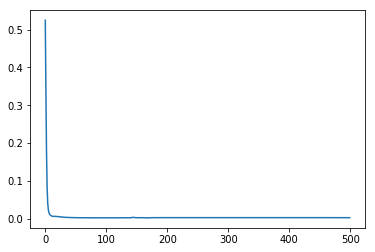

In [100]:
plt.plot(log)